In [2]:
import pandas as pd
import numpy as np
import cv2
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Activation, Subtract
from keras.optimizers import RMSprop, Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy, mae
from keras import backend as K
from keras import Sequential
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import concatenate
import random
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!mkdir dataset
!mv seen-dataset.zip dataset
!unzip dataset/seen-dataset.zip -d dataset

# Seen Dataset

In [0]:
# ENV VARS
#stickyPath = "../../dataset/seen-dataset/TrainingSet/"
# For Collab
stickyPath = "./"

In [0]:
lookupSeenTrain = pd.read_csv(str(stickyPath+"dataset/seen-dataset/dataset_seen_training_siamese.csv"))
lookupSeenTrain.sample(frac=1).reset_index(drop=True)
lookupSeenValidate = pd.read_csv(str(stickyPath+"dataset/seen-dataset/dataset_seen_validation_siamese.csv"))
lookupSeenValidate.sample(frac=1).reset_index(drop=True)
inputShape = np.shape(cv2.imread(str(stickyPath+"dataset/seen-dataset/TrainingSet/0001a_num4.png"),cv2.IMREAD_GRAYSCALE))

In [0]:
class genDataSeen(Sequence):
    def __init__(self,lookupSeenTrain,batchSize,action,flag):
        self.lookupSeenTrain, self.batchSize = lookupSeenTrain,batchSize
        self.action = action
        self.hshift = (-64,64)
        self.vshift = (-64,64)
        self.flag = flag
        if(action=='train'):
            self.stickyPath = "./dataset/seen-dataset/TrainingSet/"
        if(action=='validate'):
            self.stickyPath = "./dataset/seen-dataset/ValidationSet/"
    
    def __len__(self):
        return (int(np.floor(len(self.lookupSeenTrain) / float(self.batchSize))))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = lookupSeenTrain.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self,idx):
        leftImages = list(self.lookupSeenTrain.left[idx*self.batchSize:(idx+1)*self.batchSize])
        rightImages = list(self.lookupSeenTrain.right[idx*self.batchSize:(idx+1)*self.batchSize])
        labels = list(self.lookupSeenTrain.label[idx*self.batchSize:(idx+1)*self.batchSize])
        
        skeleton = []
        for image in range(self.batchSize):
            leftImage = cv2.imread(str(self.stickyPath+
                                       leftImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            rightImage = cv2.imread(str(self.stickyPath+
                                       rightImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            # Floating Point
            leftImage = leftImage.astype('float32')
            leftImage /= 255
            rightImage = rightImage.astype('float32')
            rightImage /= 255
            
            # Shifting
            randH = np.random.randint(self.hshift[0],self.hshift[1])
            randV = np.random.randint(self.vshift[0],self.vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)

            # Random Swap
            if(int(np.random.binomial(1, 0.5, 1)) == 1):
                temp = [rightImageShiftedV,leftImageShiftedH]
            else:
                temp = [leftImageShiftedH,rightImageShiftedV]
            skeleton.append(temp)

        skeleton = np.array(skeleton)
        left = []
        left.append(skeleton[:,0,:,:])
        left = np.array(left)
        right = []
        right.append(skeleton[:,1,:,:])
        right = np.array(right)
        if(self.flag=='cnn'):
            left = left.reshape((batchSize,64,64,1))
            right = right.reshape((batchSize,64,64,1))
            return ([left,right],np.array(labels))
        else:
            return ([skeleton[:,0,:,:],skeleton[:,1,:,:]],np.array(labels))

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

## Baseline Model

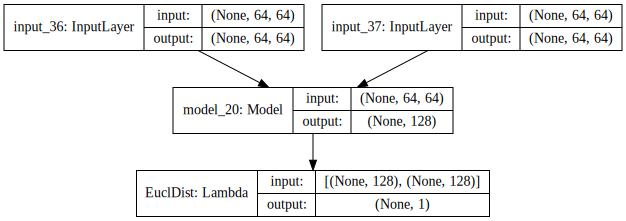

In [0]:
inputShape = np.shape(cv2.imread(str(stickyPath+"dataset/seen-dataset/TrainingSet/0001a_num4.png"),cv2.IMREAD_GRAYSCALE))
def create_base_network(input_shape):
    '''
    Base network to be shared (eq. to feature extraction).
    Ref: Keras Documentation on MNNIST Siamese
    '''
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(_input, x)
base_network = create_base_network(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = base_network(inputLeft)
processed_right = base_network(inputRight)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape,name="EuclDist")([processed_left, processed_right])
model = Model([inputLeft, inputRight], distance)
rms = RMSprop(lr=0.01)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
batchSize = 125
numEpochs = 50
initialEpoch = 0
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","nn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","nn")
display(SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64)

## Modified Baseline

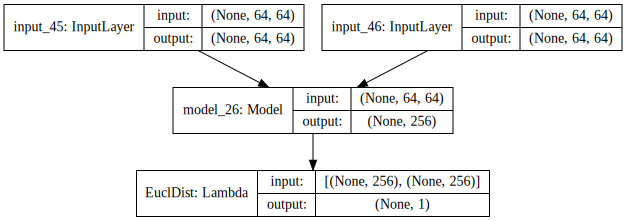

In [0]:
inputShape = np.shape(cv2.imread(str(stickyPath+"dataset/seen-dataset/TrainingSet/0001a_num4.png"),cv2.IMREAD_GRAYSCALE))
def create_base_network(input_shape):
    '''
    Base network to be shared (eq. to feature extraction).
    Ref: Keras Documentation on MNNIST Siamese
    '''
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    return Model(_input, x)
base_network = create_base_network(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = base_network(inputLeft)
processed_right = base_network(inputRight)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape,name="EuclDist")([processed_left, processed_right])
model = Model([inputLeft, inputRight], distance)
model.compile(loss=contrastive_loss, optimizer=Adam(lr=0.1), metrics=[accuracy])
batchSize = 125
numEpochs = 50
initialEpoch = 0
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","nn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","nn")
display(SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64)

## Model 2 Siamese

In [0]:
inputShape = (64, 64, 1)
def caffeReplicatedModel(input_shape):
    _input = Input(input_shape)
    x = Conv2D(filters=20,kernel_size=5,
                     kernel_initializer="glorot_normal",
                     strides=1,activation="relu",
                     use_bias=False)(_input)
    x = MaxPooling2D(pool_size=2,strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=20,kernel_size=5,
                     kernel_initializer="glorot_normal",
                     strides=1,activation="relu",
                     use_bias=False)(x)
    x = MaxPooling2D(pool_size=2,strides=2)(x)
    x = Flatten()(x)
    return Model(_input, x)
nw2 = caffeReplicatedModel(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = nw2(inputLeft)
processed_right = nw2(inputRight)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_left, processed_right])
model = Model([inputLeft, inputRight], distance)
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
batchSize = 10
numEpochs = 5
initialEpoch = 0

In [0]:
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","cnn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","cnn")

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64)

In [0]:
## Best Model

Instructions for updating:
Colocations handled automatically by placer.


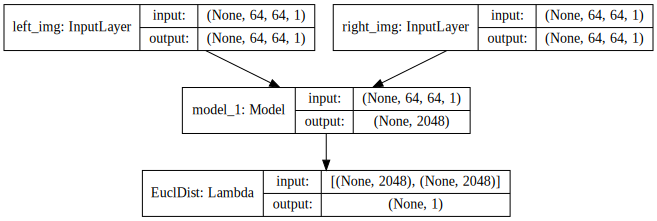

In [10]:
inputShape = (64, 64, 1)

def featureGenCNN(input_shape):
  _input = Input(input_shape)
  layer = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same',
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001), bias_regularizer=l1_l2(l1=0.01, l2=0.01))(_input)
  layer = MaxPooling2D((2,2))(layer)
  layer = Conv2D(64, (3, 3), activation='relu',padding='same',
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001), bias_regularizer=l1_l2(l1=0.01, l2=0.01))(layer)
  layer = MaxPooling2D((2,2))(layer)
  layer = Conv2D(32, (1, 1), activation='relu',padding='same',
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001), bias_regularizer=l1_l2(l1=0.01, l2=0.01))(layer)
  layer = MaxPooling2D((2,2))(layer)
  layer = Flatten()(layer)
  return Model(_input,layer)

featureGeneratorModel = featureGenCNN(inputShape)
leftDataLayer = Input(shape = inputShape, name = 'left_img')
rightDataLayer = Input(shape = inputShape, name = 'right_img')

left_feats = featureGeneratorModel(leftDataLayer)
right_feats = featureGeneratorModel(rightDataLayer)

distanceLayer = Lambda(euclidean_distance,
                       output_shape=eucl_dist_output_shape,name="EuclDist")([left_feats, right_feats])

siameseDistPlus = Model([leftDataLayer, rightDataLayer], distanceLayer)

rms = RMSprop()

siameseDistPlus.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
display(SVG(model_to_dot(siameseDistPlus, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

In [0]:
batchSize = 512
numEpochs = 50
initialEpoch = 0

trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","cnn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","cnn")

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)


In [12]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

!unzip ngrok-stable-linux-amd64.zip

--2019-03-30 13:08:09--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.207.111.186, 52.21.103.149, 34.206.9.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.207.111.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.28M  3.85MB/s    in 3.7s    

2019-03-30 13:08:14 (3.85 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
LOG_DIR = './log'

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [21]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://2c900d6d.ngrok.io


In [0]:
siameseDistPlus.fit_generator(generator=trainingBatchGen,
                              steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                              epochs=numEpochs,
                              verbose=1,
                              validation_data=validateBatchGen,
                              validation_steps=(len(lookupSeenValidate) // batchSize),
                              use_multiprocessing=True,
                              initial_epoch=0,
                              workers=128,
                              max_queue_size=64,
                              callbacks=[checkpoint,tbCallBack])